In [1]:
import sys
print(sys.version)

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
# %config InlineBackend.figure_format = 'svg' # Makes the images look nice

from qiskit import(
  QuantumCircuit,
  QuantumRegister, ClassicalRegister,
  execute,
  Aer)
from qiskit.visualization import plot_histogram

3.8.1 (tags/v3.8.1:1b293b6006, Jan  6 2020, 11:40:25) 
[GCC 9.2.1 20191008]


In [6]:
# Example #1: H^(2) * C_10 * H^(2) == C_01

H_2D = np.array([[1,1,1,1],[1,-1,1,-1],[1,1,-1,-1],[1,-1,-1,1]]) / 2
C_10 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
C_01 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

print(H_2D.dot(C_10).dot(H_2D))
print(C_01)

[[1. 0. 0. 0.]
 [0. 0. 0. 1.]
 [0. 0. 1. 0.]
 [0. 1. 0. 0.]]
[[1 0 0 0]
 [0 0 0 1]
 [0 0 1 0]
 [0 1 0 0]]


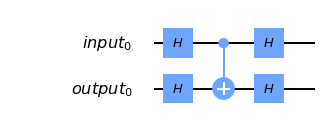

In [2]:
# draw the left side of the above equation
i = QuantumRegister(1, "input")
o = QuantumRegister(1, "output")
c = QuantumCircuit(i, o)
c.h(i)
c.h(o)
c.cx(i,o)
c.h(i)
c.h(o)
c.draw(output="mpl")

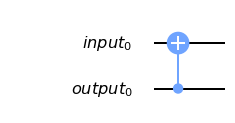

In [3]:
# draw the right side of the above equation
i = QuantumRegister(1, "input")
o = QuantumRegister(1, "output")
c = QuantumCircuit(i, o)
c.cx(o,i)
c.draw(output="mpl")

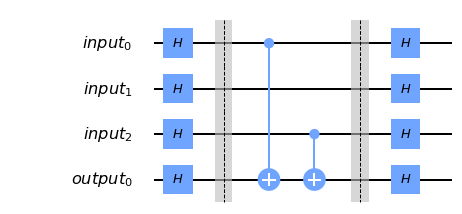

In [5]:
# 3 bit example. key=101
i = QuantumRegister(3, "input")
o = QuantumRegister(1, "output")
c = QuantumCircuit(i, o)
c.h(i)
c.h(o)
c.barrier()
# key = 101
c.cx(i[0],o)
c.cx(i[2],o)

c.barrier()
c.h(i)
c.h(o)
c.draw(output="mpl")

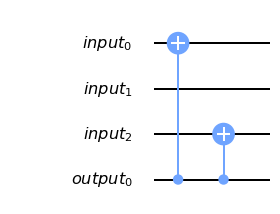

In [7]:
# 3 bit example. key=101
i = QuantumRegister(3, "input")
o = QuantumRegister(1, "output")
c = QuantumCircuit(i, o)
c.cx(o,i[0])
c.cx(o,i[2])
c.draw(output="mpl")

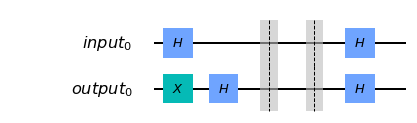

In [19]:
# draw the hadamard wrapping of the oracle

# initialize quantum registers
i = QuantumRegister(1, "input")
o = QuantumRegister(1, "output")
# initialize quantum circuit
c = QuantumCircuit(i, o)
# initialize states
c.x(o)
c.h(i)
c.h(o)
# placeholder for the oracle
c.barrier()
c.barrier()
# hadamards
c.h(i)
c.h(o)
# draw
c.draw(output="mpl")

In [66]:
# a helper class for defining quantum circuits

class Gate(object):
    amount_of_qbits = 3
    amount_of_cbits = 1
    display_gate = False
    
    def draw(self, output="mpl"):
        # if the circuit is not initialized
        if getattr(self, "circuit", None) is None:
            # then initialize it
            self.execute()

        return self.circuit.draw(output=output)
    
    def prepare_initial_state(self, initial_state):
        # the initial state of a quantum register is |0>
        # thus, to get the |1> state, a X gate is applied
        for i in range(len(initial_state)):
            if initial_state[i] == '1':
                self.circuit.x(i)
    
    def logic(self):
        raise NotImplementedError()
    # in a basic case, self.logic is enough
    # in the BernsteinVazirani, for example, it is nice to split it into several functions
    def pre_logic(self):
        pass
    def post_logic(self):
        pass
    def measure(self):
        pass


    # helper function
    def get_output_state(self):
        simulator = Aer.get_backend('statevector_simulator')
        job = execute(self.circuit, simulator)
        result = job.result()
        outputstate = result.get_statevector(self.circuit, decimals=3)    

        return outputstate

    # helper function
    @staticmethod
    def outputstate_to_bin(outputstate):
        # get amount of bits
        l = np.log2(len(outputstate))
        # find every index where there is a non-zero probability
        #indexes = np.where(res != 0)[0]
        indexes = np.where(outputstate)[0]
        # convert it to bin
        s = [bin(i)[2:] for i in indexes]
        # pad with zeros
        s = [
            '0'*int(l-len(i)) + i
            for i in s
        ]
        # move lowest bit to the right
        s = [i[::-1] for i in s]
        # return all the results
        return ' & '.join(s)

    def initialize_circuit(self):
        self.circuit = QuantumCircuit(self.amount_of_qbits, self.amount_of_cbits)
        
    def execute(self, state="0", raw=False):
        self.initialize_circuit()
        self.prepare_initial_state(state)
        
        self.pre_logic()
        self.logic()
        self.post_logic()
        self.measure()
        
        if self.display_gate:
            self.print()
        
        outputstate = self.get_output_state()
        if raw:
            return outputstate
        else:
            return self.outputstate_to_bin( outputstate )

# quantum implementation of classical gates
class AND(Gate):
    def logic(self):
        self.circuit.cswap(0,1,2)
        self.circuit.cnot(2,1)
        self.circuit.measure(2,0)

class AND2(Gate):
    def logic(self):
        self.circuit.ccx(0,1,2)
        self.circuit.measure(2,0)

class XOR(Gate):
    def logic(self):
        self.circuit.cnot(0,2)
        self.circuit.cnot(1,2)
        self.circuit.measure(2,0)

class XOR2(Gate):
    amount_of_qbits = 2
    def logic(self):
        self.circuit.cnot(0,1)
        self.circuit.measure(1,0)
        self.circuit.cnot(0,1)

class OR(Gate):
    def logic(self):
        self.circuit.x(0)
        self.circuit.x(1)
        self.circuit.ccx(0,1,2)
        self.circuit.x(2)
        # restore input bits
        self.circuit.x(0)
        self.circuit.x(1)
        
        self.circuit.measure(2,0)


class BernsteinVazirani(Gate):
    # key[i] is the i bit. => lowest bit on the left
    key = '1010'

    @property
    def key_size(self):
        return len(self.key)
    
    @property
    def amount_of_qbits(self):
        # n for input, 1 for output --> n+1
        return self.key_size + 1

    def initialize_circuit(self):
        # qr/cr stands for quantum/classical register
        self.qr  = QuantumRegister(self.key_size, 'x') # x for the input bits
        self.out = QuantumRegister(1, 'output')
        self.cr = ClassicalRegister(self.amount_of_cbits, 'c')
        
        self.circuit = QuantumCircuit(self.qr, self.out, self.cr)

    def set_oracle(self):
        # apply BernsteinVazirani black box
        for i in range(self.key_size):
            if self.key[i] == '1':
                self.circuit.cx(self.qr[i], self.out)
        
    def logic(self):
        self.set_oracle()

    def post_logic(self):
        self.circuit.barrier()

    def measure(self):
        self.circuit.measure(self.key_size,0)

        
class BernsteinVazirani_Hadamard(BernsteinVazirani):
    # key[i] is the i bit. => lowest bit on the left
    key = '1101'

    @property
    def key_size(self):
        return len(self.key)
    
    @property
    def amount_of_cbits(self):
        return self.key_size
    @property
    def amount_of_qbits(self):
        return self.key_size + 1


    def pre_logic(self):
        # initialize the ancilla to |->
        self.circuit.x(self.out)
        self.circuit.h(self.out)
        # initialize the input to |+>
        self.circuit.h(self.qr)
        
        self.circuit.barrier()

    def logic(self):
        self.set_oracle()

    def post_logic(self):
        self.circuit.barrier()
        
        # revert the hadamard
        self.circuit.h(self.qr)

    def measure(self):
        self.circuit.measure(self.qr, self.cr)


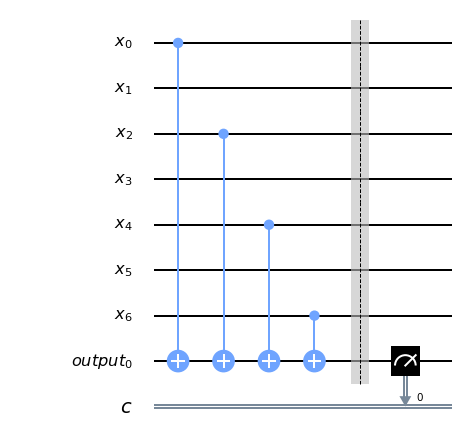

In [70]:
# draw BernsteinVazirani gates with different keys

b = BernsteinVazirani()
b.key = "11"
b.key = "1010101"
b.execute('00')
b.draw()

In [54]:
# test BernsteinVazirani gates by bruteforcing every possible input

b = BernsteinVazirani()
key_size = len(b.key)
combinations = [bin(i)[2:] for i in range(2**key_size)]
combinations = ['0'*(key_size-len(i)) + i for i in combinations]
print("combinations :   ", combinations)


for i in combinations:
    res = b.execute(i)
    print(f"{i} : {res[:-1]} {res[-1]}")

combinations :    ['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']
0000 : 0000 0
0001 : 0001 0
0010 : 0010 1
0011 : 0011 1
0100 : 0100 0
0101 : 0101 0
0110 : 0110 1
0111 : 0111 1
1000 : 1000 1
1001 : 1001 1
1010 : 1010 0
1011 : 1011 0
1100 : 1100 1
1101 : 1101 1
1110 : 1110 0
1111 : 1111 0


11010 & 11011


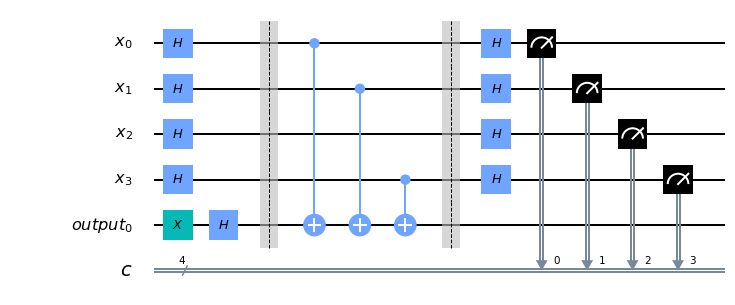

In [55]:
# draw BernsteinVazirani gates, with hadamard wrapping, with different keys

b2 = BernsteinVazirani_Hadamard()
res = b2.execute('0000')
print(res)
b2.draw()